In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [4]:
# agent compilation
l = 1.
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)
a.actor.load_weights('./saved_agent/learned_self_clipped3_actor.h5')

In [5]:
def value_function_ap(state, agent):
    # Q(s,a)
    assert agent.compiled == True
    state_ = np.array([[state]])
    action_ = agent.actor.predict(state_)
    value_function = agent.critic.predict([action_, state_])[0][0] #Q(a,s)
    return value_function

def critic_output(state, action, agent):
    state_ = np.array([[state]])
    action_ = np.array([action])
    out = agent.critic.predict([action_, state_])[0][0]
    return out
    
def recurrence_formula(reward, state1, agent, gamma=0.99):
    value = reward
    value += gamma * value_function_ap(state1, agent)
    
    return value

def all_term(state0, action, reward, state1, agent, gamma=0.99):
    q = critic_output(state0, action, agent)
    v = value_function_ap(state1, agent)
    print(f'Q(s,a): {q}')
    print(f'r(s,a): {reward}')
    print(f'γV(s`): {gamma * v}, V(s`): {v}')
    print()
    print(f'left: {q}, right: {reward + v}')

In [95]:
a.critic.load_weights('./saved_agent/learned_self_clipped3_critic_supervised.h5')
i = 5
all_term(state0_batch[i], action_batch[i], reward_batch[i], state1_batch[i], a)

Q(s,a): 34.185882568359375
r(s,a): 0.27837786376534274
γV(s`): 33.767159614562985, V(s`): 34.10824203491211

left: 34.185882568359375, right: 34.38661989867745


## 学習後のcriticと, 教師あり学習のcriticが, replay_bufferに対してlossをどちらの方が小さくできるか調べる

In [56]:
# replay buffer
df = pd.read_csv('./csv/replay_buffer.csv', index_col=0)
replay_buffer = np.array(df.values)
state0_batch = replay_buffer[:,:2]
action_batch = replay_buffer[:,2:4]
reward_batch = replay_buffer[:,4]
state1_batch = replay_buffer[:,5:7]
terminal1_batch = replay_buffer[:,7]

In [57]:
# RL critic
a.critic.load_weights('./saved_agent/learned_self_clipped3_critic.h5')

mse = 0
for i in range(len(replay_buffer)):
    print(f'{int(i*100/len(replay_buffer))}% \r', end='')
    TD = critic_output(state0_batch[i,:], action_batch[i,:], a) - recurrence_formula(reward_batch[i], state1_batch[i,:], a)
    mse += TD**2
mse /= len(replay_buffer)
print(mse)

0.028935774307992695


In [58]:
# supervised critic
a.critic.load_weights('./saved_agent/learned_self_clipped3_critic_supervised.h5')

mse = 0
for i in range(len(replay_buffer)):
    print(f'{int(i*100/len(replay_buffer))}% \r', end='')
    TD = critic_output(state0_batch[i,:], action_batch[i,:], a) - recurrence_formula(reward_batch[i], state1_batch[i,:], a)
    mse += TD**2
mse /= len(replay_buffer)
print(mse)

0.17485709798292914


In [59]:
# supervised dist critic
a.critic.load_weights('./saved_agent/learned_self_clipped3_critic_supervised_dist.h5')

mse = 0
for i in range(len(replay_buffer)):
    print(f'{int(i*100/len(replay_buffer))}% \r', end='')
    TD = critic_output(state0_batch[i,:], action_batch[i,:], a) - recurrence_formula(reward_batch[i], state1_batch[i,:], a)
    mse += TD**2
mse /= len(replay_buffer)
print(mse)

0.04267499537464296


# 教師データの分布の違いを見ていく

#### DDPG
ただし, このデータで収束を待ったわけではない

In [6]:
df = pd.read_csv('./csv/replay_buffer.csv', index_col=0)
replay_buffer = np.array(df.values)
state0_batch = replay_buffer[:,:2]
action_batch = replay_buffer[:,2:4]
reward_batch = replay_buffer[:,4]
state1_batch = replay_buffer[:,5:7]
df.shape

(49998, 8)

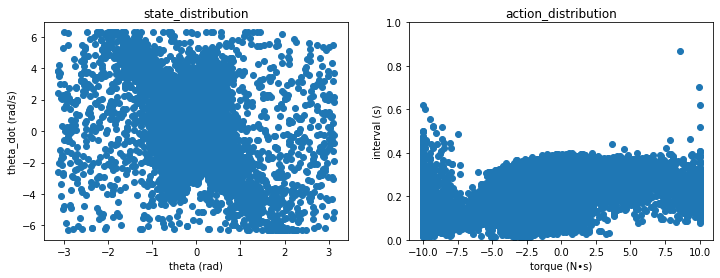

In [3]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.scatter(state0_batch[:,0], state0_batch[:,1])
ax1.set_xlabel('theta (rad)')
ax1.set_ylabel('theta_dot (rad/s)')
ax1.set_title('state_distribution')
ax2 = plt.subplot(122)
ax2.scatter(action_batch[:,0], action_batch[:,1])
ax2.set_xlabel('torque (N•s)')
ax2.set_ylabel('interval (s)')
ax2.set_title('action_distribution')
ax2.set_ylim(0,1)
plt.show()

In [51]:
tmp = []
for i, state in enumerate(state0_batch):
    if np.linalg.norm(state-[1.0,2.0]) < 0.1:
        tmp.append(action_batch[i])
tmp = np.array(tmp)
tmp.shape

(1, 2)

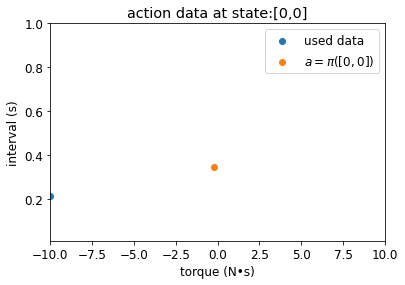

In [52]:
pi_s = a.actor.predict(np.array([[[0,0]]]))
plt.scatter(tmp[:,0], tmp[:,1], label='used data')
plt.scatter(pi_s[:,0], pi_s[:,1], label='$a=\pi([0, 0])$')
plt.xlim(-10., 10.)
plt.ylim(0.01,1.)
plt.rcParams["font.size"] = 12
plt.title('action data at state:[0,0]')
plt.xlabel('torque (N•s)')
plt.ylabel('interval (s)')
plt.legend()


0.1687032522751711 0.043755108668470016


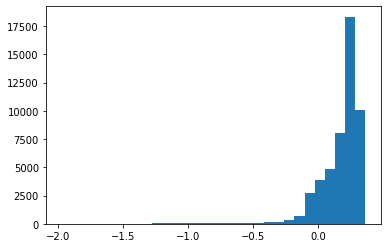

In [79]:
print(np.mean(reward_batch), np.var(reward_batch))
plt.hist(reward_batch[reward_batch>-2], bins=30)
plt.show()

#### supervised (episodic data)

In [72]:
df = pd.read_csv('./csv/replay_buffer_supervised.csv', index_col=0)
replay_buffer = np.array(df.values)
state0_batch = replay_buffer[:,:2]
action_batch = replay_buffer[:,2:4]
reward_batch = replay_buffer[:,4]
state1_batch = replay_buffer[:,5:7]
df.shape

(54416, 7)

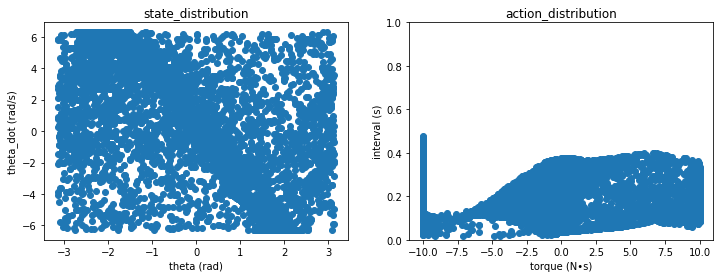

In [53]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.scatter(state0_batch[:,0], state0_batch[:,1])
ax1.set_xlabel('theta (rad)')
ax1.set_ylabel('theta_dot (rad/s)')
ax1.set_title('state_distribution')
ax2 = plt.subplot(122)
ax2.scatter(action_batch[:,0], action_batch[:,1])
ax2.set_xlabel('torque (N•s)')
ax2.set_ylabel('interval (s)')
ax2.set_title('action_distribution')
ax2.set_ylim(0,1)
plt.show()

0.3084265595343691 0.006972024219031522


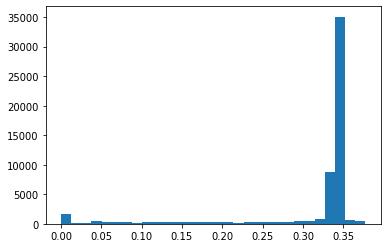

In [73]:
print(np.mean(reward_batch), np.var(reward_batch))
plt.hist(reward_batch, bins=30)
plt.show()

#### supervised (random pair)

In [68]:
df = pd.read_csv('./csv/replay_buffer_dist.csv', index_col=0)
replay_buffer = np.array(df.values)
state0_batch = replay_buffer[:,:2]
action_batch = replay_buffer[:,2:4]
reward_batch = replay_buffer[:,4]
state1_batch = replay_buffer[:,5:7]
df.shape

(20000, 7)

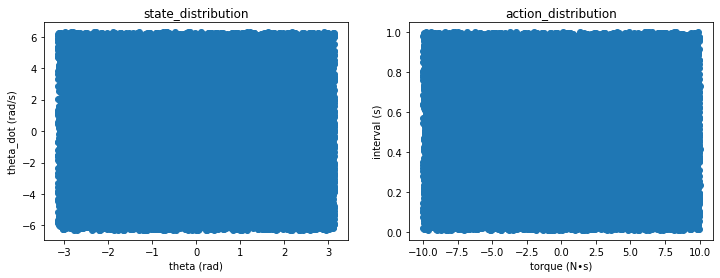

In [44]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.scatter(state0_batch[:,0], state0_batch[:,1])
ax1.set_xlabel('theta (rad)')
ax1.set_ylabel('theta_dot (rad/s)')
ax1.set_title('state_distribution')
ax2 = plt.subplot(122)
ax2.scatter(action_batch[:,0], action_batch[:,1])
ax2.set_xlabel('torque (N•s)')
ax2.set_ylabel('interval (s)')
ax2.set_title('action_distribution')
plt.show()

0.3368240057636899 0.06601536252380753


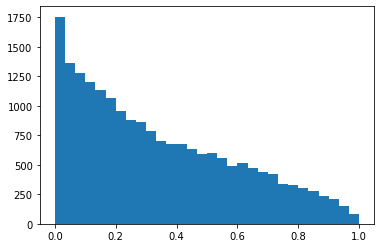

In [71]:
print(np.mean(reward_batch), np.var(reward_batch))
plt.hist(reward_batch, bins=30)
plt.show()

In [33]:
arr = np.random.randn(200).reshape(200,1)

In [41]:
np.random.seed(seed=0)
print(np.random.randn())
np.random.seed(seed=0)
print(np.random.randn())

1.764052345967664
1.764052345967664
